Project is derived from a 24-hr McKinsey Hackathon 19 Nov 17. 
https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-hackathon/?utm_source=sendinblue&utm_campaign=McKinsey_Hackathon__Go_live&utm_medium=email

Scenario: You are working with the government to transform your city into a smart city. The vision is to convert it into a digital and intelligent city to improve the efficiency of services for the citizens. One of the problems faced by the government is traffic. You are a data scientist working to manage the traffic of the city better and to provide input on infrastructure planning for the future.
 
The government wants to implement a robust traffic system for the city by being prepared for traffic peaks. They want to understand the traffic patterns of the four junctions of the city. Traffic patterns on holidays, as well as on various other occasions during the year, differ from normal working days. This is important to take into account for your forecasting. 
 
Task: To predict traffic patterns in each of these four junctions for the next 4 months.

Data: The sensors on each of these junctions were collecting data at different times, hence you will see traffic data from different time periods. To add to the complexity, some of the junctions have provided limited or sparse data requiring thoughtfulness when creating future projections. Depending upon the historical data of 20 months, the government is looking to you to deliver accurate traffic projections for the coming four months. Your algorithm will become the foundation of a larger transformation to make your city smart and intelligent.

The evaluation metric for the competition is RMSE. Public-Private split for the competition is 25:75.

Data Dictionary        Variable Definition

                  ID   Unique ID

            DateTime   Hourly Datetime Variable

            Junction   Junction Type

            Vehicles   Number of Vehicles (Target)

In [15]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [16]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))

Read in excel file (first tab)

In [132]:
df = pd.read_excel('train_data.xlsx')

Take a peak (could use df.head()...)

In [133]:
df[:5]

,DateTime,Date,Day,Hour,Year,Month,Junction,Weekend,Holiday,ID,Vehicles
0,2015-11-01 00:00:00,2015-11-01,Sunday,00:00,2015,Nov,1,True,False,20151101001,15
1,2015-11-01 01:00:00,2015-11-01,Sunday,01:00,2015,Nov,1,True,False,20151101011,13
2,2015-11-01 02:00:00,2015-11-01,Sunday,02:00,2015,Nov,1,True,False,20151101021,10
3,2015-11-01 03:00:00,2015-11-01,Sunday,03:00,2015,Nov,1,True,False,20151101031,7
4,2015-11-01 04:00:00,2015-11-01,Sunday,04:00,2015,Nov,1,True,False,20151101041,9


Determine types of each attribute (column)

In [134]:
df.dtypes

DateTime    datetime64[ns]
Date        datetime64[ns]
Day                 object
Hour                object
Year                 int64
Month               object
Junction             int64
Weekend               bool
Holiday               bool
ID                   int64
Vehicles             int64
dtype: object

Convert Year and Junction to objects (categorical variables)

In [135]:
df['Year'] = df['Year'].astype(object);
df['Junction'] = df['Junction'].astype(object); 

In [136]:
df.dtypes

DateTime    datetime64[ns]
Date        datetime64[ns]
Day                 object
Hour                object
Year                object
Month               object
Junction            object
Weekend               bool
Holiday               bool
ID                   int64
Vehicles             int64
dtype: object

In [21]:
%matplotlib inline

Quick look at univariate distribution of vehicles across all 4 intersections. By default, distplot() fits a kernel density estimate (KDE).

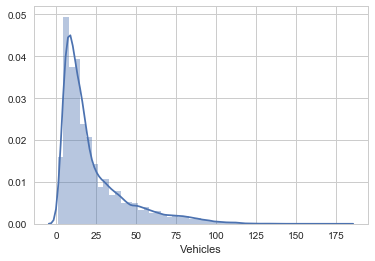

In [22]:
sns.distplot(df.Vehicles)

Observation: Heavily skewed distribution of vehicles.  

### Categorical scatterplots
#### Strip Plot
Quantitative variable across the levels of a categorical variable uses stripplot(), which generalizes a scatterplot to the case where one of the variables is categorical:

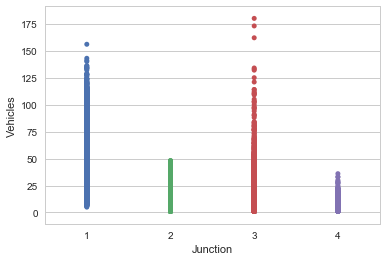

In [28]:
sns.stripplot(x="Junction", y="Vehicles", data=df);

Observation: Disparate junction vehicle distribution

#### Jitter Plot 
In a strip plot, the scatterplot points will usually overlap. This makes it difficult to see the full distribution of data. One easy solution is to adjust the positions (only along the categorical axis) using some random “jitter”

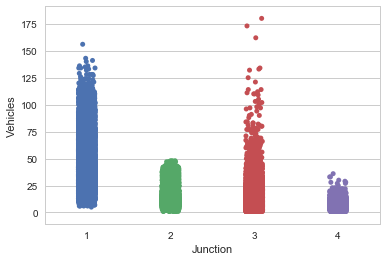

In [25]:
sns.stripplot(x="Junction", y="Vehicles", data=df, jitter=True);

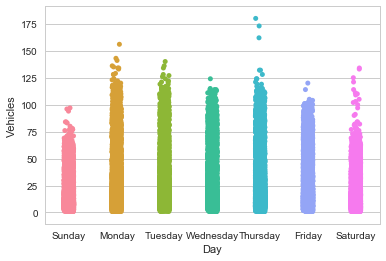

In [57]:
sns.stripplot(x="Day", y="Vehicles", data=df, jitter=True);

Observation: Moreso than other junctions, 3 is highly variable and contains extreme outliers

#### Stratify by year and junction

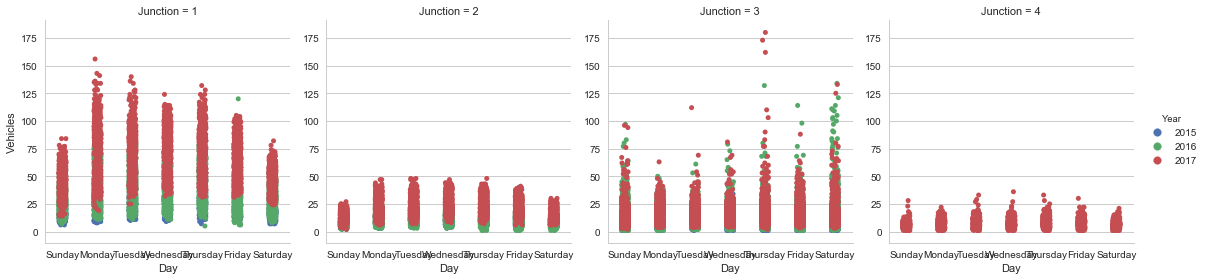

In [59]:
sns.factorplot(x="Day", y="Vehicles", hue="Year",
               col="Junction", data=df, kind="strip", jitter=True);

Observation: Junction 1 experiences highest vehicular traffic on Monday. 

#### Violin Plot
Combines a boxplot with the kernel density estimation procedure.

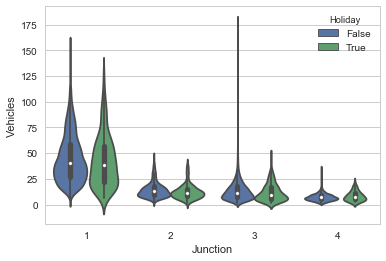

In [32]:
sns.violinplot(x="Junction", y="Vehicles", hue="Holiday", data=df)

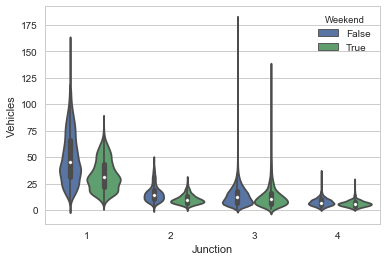

In [53]:
sns.violinplot(x="Junction", y="Vehicles", hue="Weekend", data=df)

Observation: Stratified across junctions, weekends have less spread and average less than holidays.

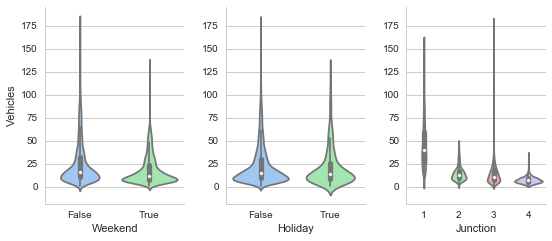

In [47]:
g = sns.PairGrid(df,
                 x_vars=["Weekend", "Holiday", "Junction"],
                 y_vars=["Vehicles"],
                 aspect=.75, size=3.5)
g.map(sns.violinplot, palette="pastel");

Observation: Supports previous two plots demonstrating weekend traffic volume is less spread and deviates less from mean.

#### Violin Plot with split
Split violins by a binary parameter 

#### Violin Plot Split by Holiday

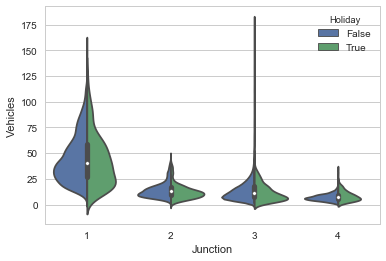

In [55]:
sns.violinplot(x="Junction", y="Vehicles", hue="Holiday", data=df, split=True);

#### Violin Plot Split by Weekend

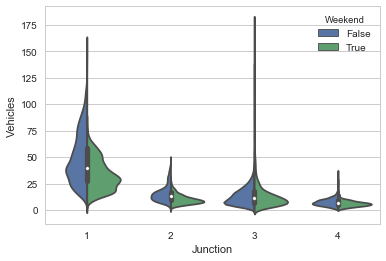

In [56]:
sns.violinplot(x="Junction", y="Vehicles", hue="Weekend", data=df, split=True);

#### Point Plot 
Rather than show a full bar plot, just plot the point estimate and confidence interval. 

#### Point Plot by Weekend

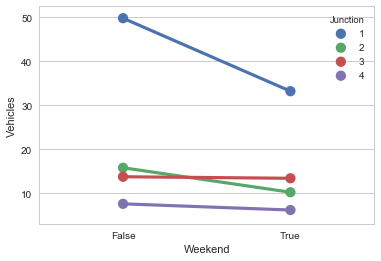

In [36]:
sns.pointplot(x="Weekend", y="Vehicles", hue="Junction", data=df)

#### Point Plot by Holiday

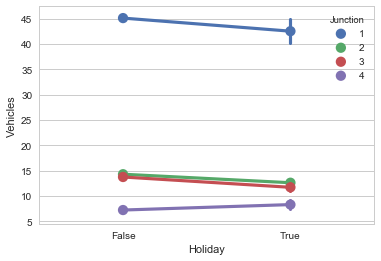

In [37]:
sns.pointplot(x="Holiday", y="Vehicles", hue="Junction", data=df)

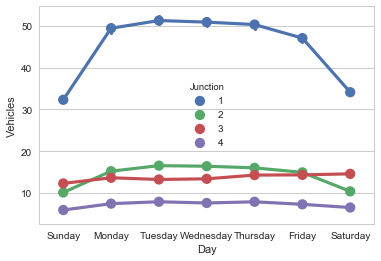

In [39]:
sns.pointplot(x="Day", y="Vehicles", hue="Junction", data=df)

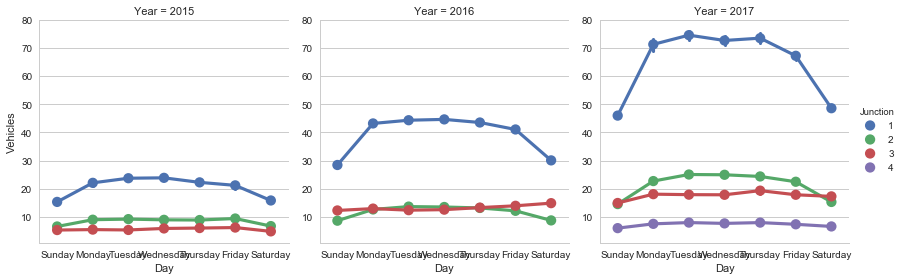

In [50]:
sns.factorplot(x="Day", y="Vehicles", hue="Junction",
               col="Year", data=df, kind="point");

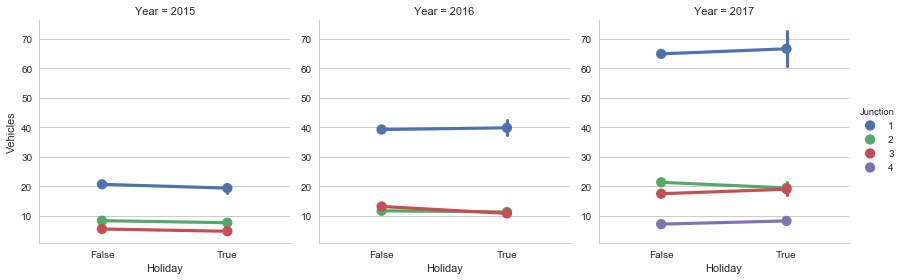

In [49]:
sns.factorplot(x="Holiday", y="Vehicles", hue="Junction",
               col="Year", data=df, kind="point");

### Machine Learrning

In [137]:
X = df.copy(deep=True)

In [138]:
X[:5]

,DateTime,Date,Day,Hour,Year,Month,Junction,Weekend,Holiday,ID,Vehicles
0,2015-11-01 00:00:00,2015-11-01,Sunday,00:00,2015,Nov,1,True,False,20151101001,15
1,2015-11-01 01:00:00,2015-11-01,Sunday,01:00,2015,Nov,1,True,False,20151101011,13
2,2015-11-01 02:00:00,2015-11-01,Sunday,02:00,2015,Nov,1,True,False,20151101021,10
3,2015-11-01 03:00:00,2015-11-01,Sunday,03:00,2015,Nov,1,True,False,20151101031,7
4,2015-11-01 04:00:00,2015-11-01,Sunday,04:00,2015,Nov,1,True,False,20151101041,9


In [140]:
X = X.drop(labels='Vehicles', axis=1)
X = X.drop(labels='DateTime', axis=1)
X = X.drop(labels='Date', axis=1)

In [141]:
X[:5]

,Day,Hour,Year,Month,Junction,Weekend,Holiday,ID
0,Sunday,00:00,2015,Nov,1,True,False,20151101001
1,Sunday,01:00,2015,Nov,1,True,False,20151101011
2,Sunday,02:00,2015,Nov,1,True,False,20151101021
3,Sunday,03:00,2015,Nov,1,True,False,20151101031
4,Sunday,04:00,2015,Nov,1,True,False,20151101041


In [142]:
y_labels = df['Vehicles']

In [143]:
y_label[:5]

0    15
1    13
2    10
3     7
4     9
Name: Vehicles, dtype: int64

In [144]:
regr = RandomForestRegressor(max_depth=32, random_state=0)

## Encode categorical features

In [146]:
X.shape  # looking for (48120, 8)

(48120, 8)

In [147]:
encoded_X = pd.get_dummies(X)
encoded_X.shape # looking for (48120, 53)

(48120, 53)

In [151]:
#encoded_X.dtypes

In [149]:
# train model with training data and labels
regr.fit(encoded_X, y_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=32,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [150]:
print(regr.feature_importances_)

[  4.88211158e-02   7.28797536e-04   2.43662131e-01   4.03038839e-03
   3.46279959e-03   3.04298269e-03   1.17107287e-03   3.18192919e-03
   1.59870899e-03   1.55442374e-03   5.02400770e-03   9.03891223e-03
   1.27444026e-02   1.55666525e-02   1.85554940e-02   1.93643170e-02
   1.82021936e-02   1.55742702e-02   1.30384035e-02   8.51797854e-03
   2.21809048e-03   1.28958166e-03   1.28869068e-03   9.64675445e-04
   9.70069844e-04   7.86111494e-04   8.61464155e-04   8.49327768e-04
   1.81618731e-03   3.11126015e-03   3.82302134e-03   2.35443278e-03
   2.31808567e-03   2.37322060e-03   1.07131842e-05   1.11819559e-04
   1.44800585e-04   1.00802667e-03   2.10877402e-04   5.15809312e-04
   5.70997516e-04   4.60785378e-04   9.83749113e-05   5.51107224e-04
   5.57636582e-04   1.13039352e-03   2.18324568e-04   2.10799020e-04
   3.18051707e-04   5.01660603e-01   3.44888314e-03   3.29411200e-03
   1.35726828e-02]


Junction 1 is most influential predictor followed by ID